Data:
https://www.kaggle.com/datasets/rachelleperez/the-bachelor-vs-the-bachelorette?datasetId=972155&sortBy=dateRun&tab=collaboration

https://www.kaggle.com/datasets/brianbgonz/the-bachelorette-contestants?select=bachelors.csv

https://github.com/chesmore/bach-stats/

In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import pickle

In [33]:
# Preprocessing
df1 = pd.read_excel('https://query.data.world/s/cmq7jujc6vymleaedtqiva6evljknv?dws=00000')
df1.columns

df1['FirstName'] = df1['Name']
df1['LastName'] = df1['Last Name']
df1.drop(columns=["Name", "Last Name", 'Followers(k)'], inplace=True)
display(df1.head())

df2 = pd.read_csv('https://raw.githubusercontent.com/chesmore/bach-stats/main/bach_data.csv')

df2['Name'] = df2['Name'].str.replace(r'\[.*\]', '')
df2['FirstName'] = df2['Name'].str.split(' ', expand=True)[0]
df2['LastName'] = df2['Name'].str.split(' ', expand=True)[1]
df2.drop(columns="Name", inplace=True)

display(df2.head())

print(df1.size)
print(df2.size)

# TODO fix the extra ten columns added during the merge
data = pd.merge(df1, df2, on=['FirstName', 'LastName', 'Age', 'Place'])
print(data.size)
data.drop_duplicates(subset=['FirstName', 'LastName'], inplace=True)
data.columns = [x.lower().replace(' ', '_') for x in data.columns] # rename columns
data = data.fillna(0) # fill nan with 0
# remove random annoying qirks
data['fir?'] = data['fir?'].replace(' ', 0)
print(data.size)
display(data.head())
data.columns

,Season,Age,City,State,Country,Occupation,Outcome,Elimination_Week,Place,Note,Was_Bachelorette,FirstName,LastName
0,18,24.0,Aurora,Illinois,USA,Marketing Manager,Week 3,3,14.0,NaN,0,Christy,Hansen
1,19,28.0,Manhattan Beach,California,USA,Cadaver Tissue Saleswoman,Week 1,1,24.0,NaN,0,Reegan,Cornwell
2,18,31.0,Apopka,Florida,USA,Massage Therapist,Week 1,1,19.0,NaN,0,Amy,Jokinen
3,18,25.0,Roanoke,Texas,USA,Grade School Teacher,Week 1,1,19.0,NaN,0,Ashley,Poe
4,19,26.0,Hasbrouck Heights,New Jersey,USA,Former NFL Cheerleader,Week 4,4,12.0,NaN,0,Nikki,Delventhal


<ipython-input-33-6ae5a9545e21>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df2['Name'] = df2['Name'].str.replace(r'\[.*\]', '')


,Age,Hometown,Job category,Race,Place,Season,1-on-1 week,FIR?,Joke Entrance,FirstName,LastName
0,25,South,REALTOR,White,2,11,NaN,NaN,NaN,DeAnna,Pappas
1,27,Midwest,DANCER,White,2,11,NaN,Yes,NaN,Jenni,Croft
2,27,Mid atlantic,REALTOR,White,3,11,NaN,NaN,NaN,Bettina,Bell
3,23,West,EXECUTIVE,White,4,11,NaN,NaN,NaN,Sheena,Stewart
4,27,Mid atlantic,MEDICAL,White,5,11,NaN,NaN,NaN,Hillary,Reisinger


5499
4642
4720
4660


,season,age,city,state,country,occupation,outcome,elimination_week,place,note,was_bachelorette,firstname,lastname,hometown,job_category,race,season_,1-on-1_week,fir?,joke_entrance
0,18,24.0,Aurora,Illinois,USA,Marketing Manager,Week 3,3,14.0,0,0,Christy,Hansen,Midwest,MARKETING,White,18,0.0,0,0
1,19,28.0,Manhattan Beach,California,USA,Cadaver Tissue Saleswoman,Week 1,1,24.0,0,0,Reegan,Cornwell,West,JOKE,White,19,0.0,0,0
2,18,31.0,Apopka,Florida,USA,Massage Therapist,Week 1,1,19.0,0,0,Amy,Jokinen,South,BEAUTY,White,18,0.0,0,0
3,18,25.0,Roanoke,Texas,USA,Grade School Teacher,Week 1,1,19.0,0,0,Ashley,Poe,South,TEACHER,White,18,0.0,0,0
4,19,26.0,Hasbrouck Heights,New Jersey,USA,Former NFL Cheerleader,Week 4,4,12.0,0,0,Nikki,Delventhal,East,DANCER,White,19,0.0,0,0


Index(['season', 'age', 'city', 'state', 'country', 'occupation', 'outcome',
       'elimination_week', 'place', 'note', 'was_bachelorette', 'firstname',
       'lastname', 'hometown', 'job_category', 'race', 'season_',
       '1-on-1_week', 'fir?', 'joke_entrance'],
      dtype='object')

In [34]:
new_job_cat = {
    'NEWS': 'POLITICS',
    'MILLITARY': 'POLITICS',
    'POLITICS': 'POLITICS',
    'MARKETING': 'CORPORATE',
    'PR': 'CORPORATE',
    'RECRUITER': 'CORPORATE',
    'ASSISTANT': 'CORPORATE',
    'EXECUTIVE': 'CORPORATE',
    'SALES': 'CORPORATE',
    'FINANCE': 'CORPORATE',
    'RESTAURANT JOB': 'TRADES',
    'WAITRESS': 'TRADES',
    'BEAUTY': 'TRADES',
    'ACTRESS/MODEL': 'TRADES',
    'DANCER': 'TRADES',
    'REALTOR': 'TRADES',
    'EVENT PLANNER': 'TRADES',
    'FITNESS': 'TRADES',
    'NANNY': 'TRADES',
    'TEACHER': 'TRADITIONAL',
    'DENTIST': 'TRADITIONAL',
    'LAWYER': 'TRADITIONAL',
    'MEDICAL': 'TRADITIONAL',
    'SCIENCE/TECHNOLOGY': 'TRADITIONAL',
    'STUDENTT': 'OTHER',
    'STUDENT': 'OTHER',
    'WRITER': 'OTHER',
    'PASTOR': 'OTHER',
    'ART': 'OTHER',
    'NONE': 'OTHER',
    'JOKE': 'OTHER',
    'FLIGHT ATTENDANT': 'OTHER'
}

data['job_category'] = data['job_category'].map(new_job_cat)


new_hometown_cat = {
    'INTERNATIONAL':['Canada','International'],
    'NE':['Midwestt','East','Midwest','Mid atlantic'],
    'NW':['West','Northwest'],
    'SE':['South',],
    'SW':['Southwest']
}

home_categories = data['hometown'].to_numpy()
new_home_categories = np.array([next((key for key, val in new_hometown_cat.items() if name in val), name) for name in home_categories])

data['hometown'] = new_home_categories
data

,season,age,city,state,country,occupation,outcome,elimination_week,place,note,was_bachelorette,firstname,lastname,hometown,job_category,race,season_,1-on-1_week,fir?,joke_entrance
0,18,24.0,Aurora,Illinois,USA,Marketing Manager,Week 3,3,14.0,0,0,Christy,Hansen,NE,CORPORATE,White,18,0.0,0,0
1,19,28.0,Manhattan Beach,California,USA,Cadaver Tissue Saleswoman,Week 1,1,24.0,0,0,Reegan,Cornwell,NW,OTHER,White,19,0.0,0,0
2,18,31.0,Apopka,Florida,USA,Massage Therapist,Week 1,1,19.0,0,0,Amy,Jokinen,SE,TRADES,White,18,0.0,0,0
3,18,25.0,Roanoke,Texas,USA,Grade School Teacher,Week 1,1,19.0,0,0,Ashley,Poe,SE,TRADITIONAL,White,18,0.0,0,0
4,19,26.0,Hasbrouck Heights,New Jersey,USA,Former NFL Cheerleader,Week 4,4,12.0,0,0,Nikki,Delventhal,NE,TRADES,White,19,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,14,25.0,San Diego,California,USA,Restaurant Manager,Week 2,2,13.0,0,0,Christina,McCasland,NW,TRADES,White,14,0.0,0,0
232,13,25.0,Dallas,Texas,USA,Sales Representative,Winner,8,1.0,0,0,Melissa,Rycroft,SW,CORPORATE,White,13,1.0,0,0
233,19,24.0,Lake in the Hills,Illinois,USA,Ballet Teacher,Week 1,1,24.0,0,0,Amanda,Goerlitz,NE,TRADES,White,19,0.0,0,0
234,20,30.0,Visalia,California,USA,Cowgirl,Week 1,1,22.0,0,0,Maegan,Miller,NW,OTHER,White,20,0.0,0,Gimmick


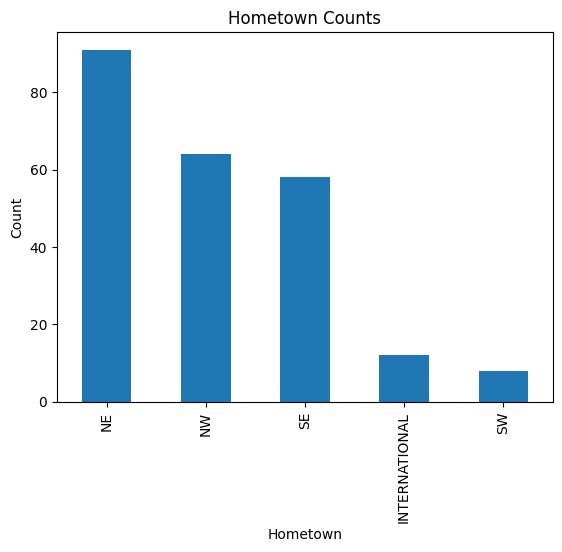

In [35]:
# Count the frequency of each unique value in the column
counts = data['hometown'].value_counts()

# Create a bar plot of the counts
counts.plot(kind='bar')
plt.title('Hometown Counts')
plt.xlabel('Hometown')
plt.ylabel('Count')
plt.show()

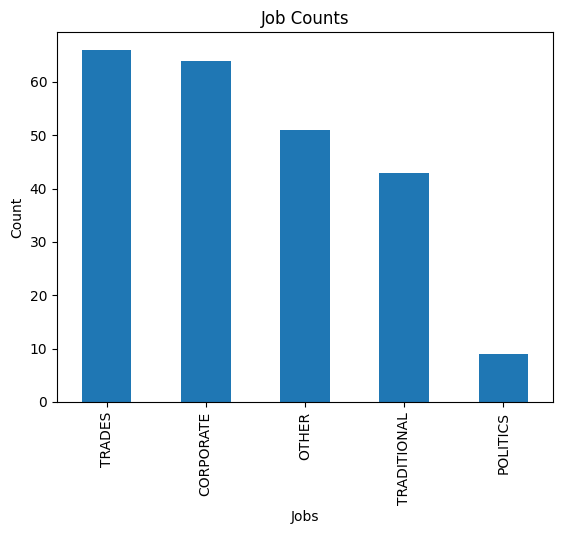

In [36]:
# Count the frequency of each unique value in the column
counts = data['job_category'].value_counts()

# Create a bar plot of the counts
counts.plot(kind='bar')
plt.title('Job Counts')
plt.xlabel('Jobs')
plt.ylabel('Count')
plt.show()

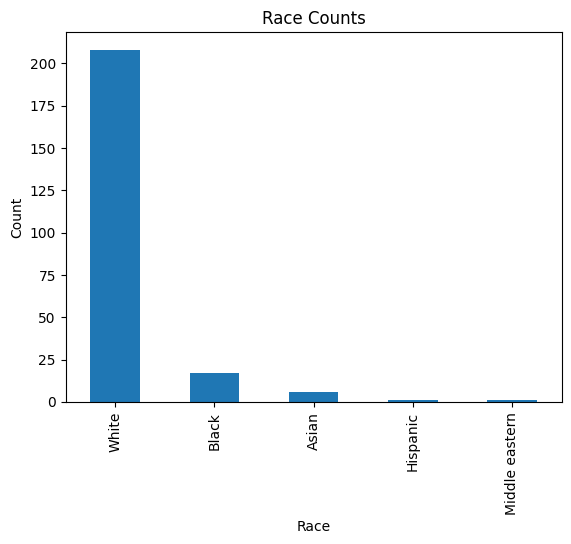

In [37]:
# Count the frequency of each unique value in the column
counts = data['race'].value_counts()

# Create a bar plot of the counts
counts.plot(kind='bar')
plt.title('Race Counts')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()

In [39]:
# encode for NN, DT - one hot encoding
one_hot_dataset = data.copy()
le = LabelEncoder()

# drop columns that cannot be encoded well
columns_to_drop = ['firstname', 'lastname', 'city', 'state', 'occupation', 'elimination_week', 'country', 'place', 'was_bachelorette', 'season_']
one_hot_dataset.drop(columns=columns_to_drop, inplace=True)

# one hot encode
columns_to_encode = ['hometown', 'note', 'job_category', 'race', 'fir?', 'joke_entrance']
one_hot_dataset = pd.get_dummies(one_hot_dataset, columns=columns_to_encode)

# ordinal encode 
one_hot_dataset['outcome'] = le.fit_transform(one_hot_dataset['outcome'])

# clean column names 
def clean_column_name(column_name):
    if column_name.startswith('race_'):
        return column_name.replace('race_', '')
    elif column_name.startswith('joke_entrance_'):
        return column_name.replace('joke_entrance_', '')
    elif column_name.startswith('fir?'):
        return column_name.replace('fir?', 'FIR')        
    elif column_name.startswith('1-on-1_week'):
        return column_name.replace('1-on-1_week', '1_on_1')  
    elif column_name.startswith('hometown_'):
        return column_name.replace('hometown_', '') 
    elif column_name.startswith('job_category_'):
        return column_name.replace('job_category_', '') 
    else:
        return column_name

# Apply the function to all column names
one_hot_dataset.columns = [clean_column_name(col) for col in one_hot_dataset.columns]

# TODO: Finalize column names
one_hot_dataset

,season,age,outcome,1_on_1,INTERNATIONAL,NE,NW,SE,SW,note_0,...,Asian,Black,Hispanic,Middle eastern,White,FIR_0,FIR_Yes,0,Gimmick,Regular
0,18,24.0,4,0.0,0,1,0,0,0,1,...,0,0,0,0,1,1,0,1,0,0
1,19,28.0,2,0.0,0,0,1,0,0,1,...,0,0,0,0,1,1,0,1,0,0
2,18,31.0,2,0.0,0,0,0,1,0,1,...,0,0,0,0,1,1,0,1,0,0
3,18,25.0,2,0.0,0,0,0,1,0,1,...,0,0,0,0,1,1,0,1,0,0
4,19,26.0,5,0.0,0,1,0,0,0,1,...,0,0,0,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,14,25.0,3,0.0,0,0,1,0,0,1,...,0,0,0,0,1,1,0,1,0,0
232,13,25.0,11,1.0,0,0,0,0,1,1,...,0,0,0,0,1,1,0,1,0,0
233,19,24.0,2,0.0,0,1,0,0,0,1,...,0,0,0,0,1,1,0,1,0,0
234,20,30.0,2,0.0,0,0,1,0,0,1,...,0,0,0,0,1,1,0,0,1,0


In [40]:
len(one_hot_dataset.columns)

27

In [41]:
# train test split
train, test = train_test_split(one_hot_dataset, test_size=0.2) 
X_train, y_train =  train.drop(['outcome'], axis=1), train['outcome']
X_test, y_test =  test.drop(['outcome'], axis=1), test['outcome']

In [42]:
# Regression

# create a logistic regression model
lreg = LogisticRegression(max_iter=1000)
lreg.fit(X_train, y_train)

# make predictions on the test data
y_pred = lreg.predict(X_test)

# calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# print the accuracy
print('Accuracy:', accuracy)

Accuracy: 0.3191489361702128


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Define the neural network architecture
model = keras.Sequential([
    layers.Dense(8, activation='relu', input_shape=(27,)),
    layers.BatchNormalization(),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2)

Epoch 1/100
10/10 [==============================] - 1s 18ms/step - loss: 0.7756 - accuracy: 0.0203 - val_loss: -43.4300 - val_accuracy: 0.0263
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0977 - accuracy: 0.0203 - val_loss: -41.4978 - val_accuracy: 0.0263
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: -0.5101 - accuracy: 0.0203 - val_loss: -40.5424 - val_accuracy: 0.0263
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: -1.1028 - accuracy: 0.0270 - val_loss: -38.6957 - val_accuracy: 0.0263
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: -1.6154 - accuracy: 0.0270 - val_loss: -38.2691 - val_accuracy: 0.0263
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: -2.2314 - accuracy: 0.0338 - val_loss: -37.8533 - val_accuracy: 0.0263
Epoch 7/100
10/10 [==============================] - 0s 5ms/step - loss: -2.6973 - accuracy: 0.0338 - val_loss: -37.7083 - val_accuracy: 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation

model = Sequential([
    Dense(27, input_shape=(27,)),
    BatchNormalization(),
    Activation('relu'),
    Dense(27),
    BatchNormalization(),
    Activation('sigmoid'),
    Dense(25), # this line is erroring, why
    Activation('softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2)

Epoch 1/100
10/10 [==============================] - 2s 66ms/step - loss: 0.3737 - accuracy: 0.0473 - val_loss: -0.6955 - val_accuracy: 0.0263
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: -0.3411 - accuracy: 0.0473 - val_loss: -1.1932 - val_accuracy: 0.0263
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: -1.0267 - accuracy: 0.0473 - val_loss: -1.6967 - val_accuracy: 0.0263
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: -1.6910 - accuracy: 0.0473 - val_loss: -2.2124 - val_accuracy: 0.0263
Epoch 5/100
10/10 [==============================] - 0s 6ms/step - loss: -2.3873 - accuracy: 0.0473 - val_loss: -2.6028 - val_accuracy: 0.0263
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: -2.9591 - accuracy: 0.0473 - val_loss: -3.0887 - val_accuracy: 0.0263
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: -3.6273 - accuracy: 0.0473 - val_loss: -3.5741 - val_accuracy: 0.0263

KeyboardInterrupt: ignored

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

2/2 [==============================] - 0s 5ms/step - loss: -1147.2561 - accuracy: 0.0000e+00
Test accuracy: 0.0


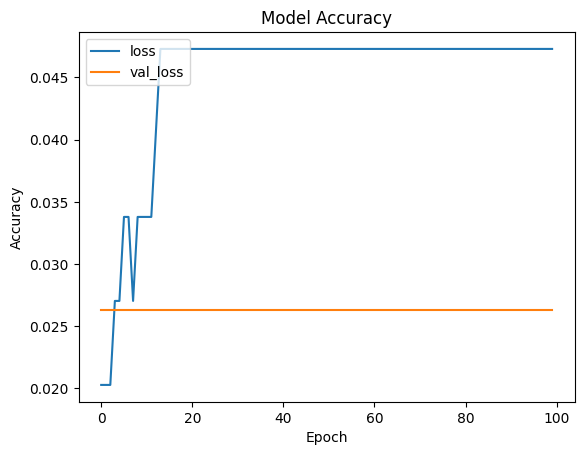

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

pandas.core.frame.DataFrame

ValueError: ignored

In [24]:
# Define your decision tree model
model = DecisionTreeClassifier()

# Define the hyperparameters to search over
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Use grid search to find the best hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and their performance
print("Best hyperparameters:", grid_search.best_params_)
print("Best performance:", grid_search.best_score_)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
Best performance: 0.39758179231863444


Accuracy: 0.3829787234042553


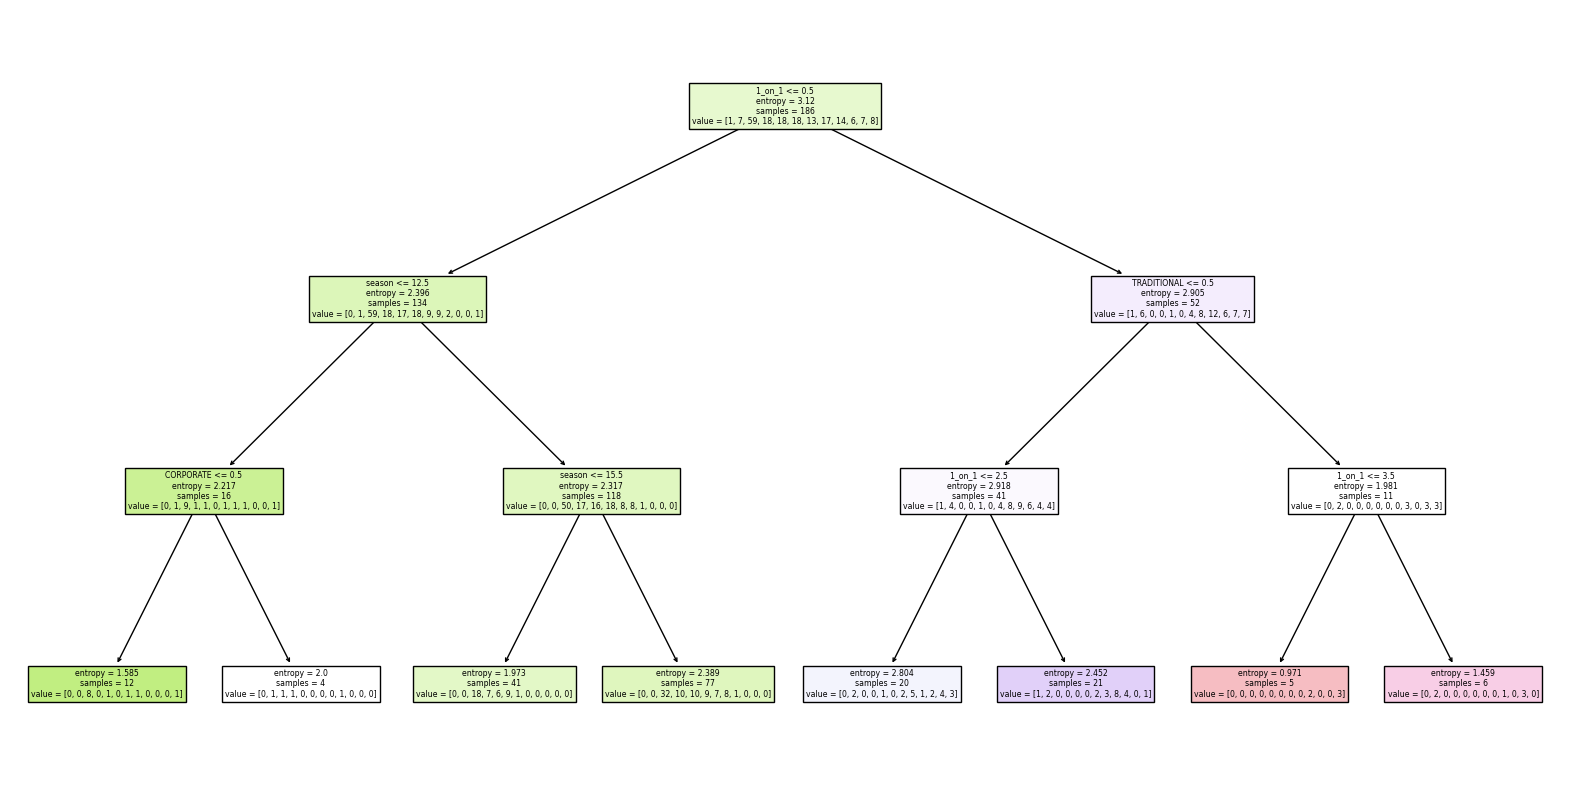

In [50]:
# Decison Tree using discorverd hyperparameters

# Define your decision tree model
decison_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=2, random_state=42)

# Train the model on the training data
decison_tree.fit(X_train, y_train)

# Predict the outcome for the testing data
y_pred = decison_tree.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(decison_tree, filled=True, feature_names=X_train.columns)
plt.show()

In [43]:
# Export model 
with open('model.pkl', 'wb') as f:
    pickle.dump(lreg, f)

## Further exploration

If given more time, I would love to explore predicting the outcome of a contestant by analyzing a headshot of the contestant. It would be interesting to see how a nueral network would perform using the image data as opposed to the categorial data I used